# Introduction

I had one goal that morphed into another while making this notebook. Initially, I wanted to demonstrate:
- Using the `Instrument` object
- Using PySM3
- A PySM3-centered executor
- A Matplotlib-centered executor

But an issue came up outside this. I wanted to compare what I get from PySM3 foreground simulations with the actual Planck maps. As I went, I thought it may be useful to present this as a "how-I-work" notebook.

For reference, about 3 hours went into making the simulated maps and the comparisons with Planck. Another 10 went into processing the map. This is probably more time than it normally would have been; I was trying to maintain a utility to this notebook as a reference.

I've cleared out the figures produced because of the large volume of space they take up. I hope you'll understand.

## Contents

First I [Set-Up](#set-up) the notebook.



There are a lot of figures generated by the notebook, which bloats the size of this. I've added a flag to disable that output for the version that goes in the main repository. Change this flag when you run the code to see everything.

In [791]:
show_figures = False

# Set-Up

There's nothing terribly interesting in the setup. The final cell in this section uses Hydra overrides.

In [1]:
# Ignore this cell. 
# It's needed for the notebook to work, not something to learn.

import sys
import os

# Set the local_system
os.environ["CMB_ML_LOCAL_SYSTEM"] = "generic_lab"

# Add the path to the parent directory so I can import cmb-ml
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, repo_root)

In [2]:
import logging

In [3]:
logger = logging.getLogger("F_Tutorial")
logger.setLevel(logging.DEBUG)

# Outside of a notebook, Hydra will handle the logging. 
handler = logging.StreamHandler()  # StreamHandler sends logs to sys.stdout by default
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

Note the overrides in the following cell. I set this up initially for a demonstration of the Instrument object. I will use overrides throughout this notebook.

The overrides allow me to make variations on the configuration. Throughout most of the notebook, I'll be producing high-resolution maps. However, at first, I'll use low resolution and a smaller subset of the detectors.

In [4]:
from omegaconf import OmegaConf
from hydra.core.hydra_config import HydraConfig
from hydra import compose, initialize

# There are better ways to do this outside of notebooks.
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoH_instrument", 
                  return_hydra_config=True,
                  overrides=["nside=32",
                             "detectors=[30,70,143,353,857]"])
    HydraConfig.instance().set_config(cfg)

# The `Instrument` object

The `Instrument` object maintains the parameters that describe the various detectors. I create it using a table containing small amount of information for each.

In [5]:
from cmbml.core import Asset, Namer
from cmbml.utils import Instrument, make_instrument
from cmbml.core.asset_handlers import QTableHandler

In order to build the instrument, I load the table. While it can be done manually, I'm going to use the CMB-ML classes to do this. First I define a `Namer` for the configuration and an `Asset` for the table with detector information.

In [6]:
name_tracker = Namer(cfg)
in_det_table: Asset = Asset(cfg, 
                            source_stage="raw",
                            asset_name="deltabandpass",
                            name_tracker=name_tracker,
                            in_or_out="in")
detector_info = in_det_table.read()

A helper function makes the `Instrument`. The object is frozen Dataclass since, once loaded, nothing needs to change. This renders it immutable, so that it can be used in thread-safe processes.

In [7]:
instrument = make_instrument(cfg, 
                             det_info=detector_info)

The Instrument contains a dictionary of Detector objects (Detector is also a frozen Dataclass).

In [8]:
instrument.dets

{30: Detector(nom_freq=30, fields='I', cen_freq=<Quantity 28.4 GHz>, fwhm=<Quantity 33.10265212 arcmin>),
 70: Detector(nom_freq=70, fields='I', cen_freq=<Quantity 70.4 GHz>, fwhm=<Quantity 13.07645961 arcmin>),
 143: Detector(nom_freq=143, fields='I', cen_freq=<Quantity 142.876 GHz>, fwhm=<Quantity 7.303 arcmin>),
 353: Detector(nom_freq=353, fields='I', cen_freq=<Quantity 357.5 GHz>, fwhm=<Quantity 4.944 arcmin>),
 857: Detector(nom_freq=857, fields='I', cen_freq=<Quantity 866.8 GHz>, fwhm=<Quantity 4.638 arcmin>)}

Note that the key for the instrument's dictionary (`freq` in the following cell) is the same as the nominal frequency for flexibility.

In [9]:
print("Frequency, Fields, Center Frequency,    FHWM")
for freq, det in instrument.dets.items():
    print(f"{freq:>3} / {det.nom_freq:>3}: {det.fields:>6}, {det.cen_freq:>12.02f}, {det.fwhm:.1f}")
del freq, det

Frequency, Fields, Center Frequency,    FHWM
 30 /  30:      I,        28.40 GHz, 33.1 arcmin
 70 /  70:      I,        70.40 GHz, 13.1 arcmin
143 / 143:      I,       142.88 GHz, 7.3 arcmin
353 / 353:      I,       357.50 GHz, 4.9 arcmin
857 / 857:      I,       866.80 GHz, 4.6 arcmin


You may notice that the scenario YAML has more detectors than I'm using. This "Full Instrument" is set up to constrain what options are available in the external science sources.

In [10]:
print(OmegaConf.to_yaml(cfg.scenario.full_instrument))

30: IQU
44: IQU
70: IQU
100: IQU
143: IQU
217: IQU
353: IQU
545: I
857: I



This is forward looking, to polarization data being used. Right now, I have just the temperature ("I" for "Intensity") field. However, if I were to use polarization fields "IQU", I would hit a barrier because the 545 and 857 GHz official releases have no polarization data. Were I to create an instrument with "IQU" and the 30 GHz, 143 GHz and 857 GHz detector, it would look like:
```text
Frequency, Fields, Center Frequency,    FHWM
 30 /  30:    IQU,        28.40 GHz, 33.1 arcmin
143 / 143:    IQU,       142.88 GHz, 7.3 arcmin
857 / 857:      I,       866.80 GHz, 4.6 arcmin
```
This way, I would have the ability to create simulations or perform other processes on across all detectors, and more easily look up the fields available. This is not a concern right now, as I have the following setting:

In [11]:
cfg.scenario.map_fields

'I'

I keep track of the detector's raw information using the definitions in a table from the PySM3 release. In the future, I would love to get more precise information from the intrument RIMOs.

In [12]:
print(detector_info)

band center_frequency     fwhm    
           GHz           arcmin   
---- ---------------- ------------
  30             28.4 33.102652125
  44             44.1  27.94348615
  70             70.4  13.07645961
 100           100.89        9.682
 143          142.876        7.303
 217          221.156        5.021
 353            357.5        4.944
 545            555.2        4.831
 857            866.8        4.638


To prevent issues, I'll be deleting things from the namespace through this notebook. It helps me ensure that I'm not using old data - as long as I've properly deleted variables. <!-- This is a pitfall of jupyter notebooks, and part of the reason I prefer to work in modules. -->

In [13]:
try:
    del name_tracker, instrument
except NameError:  # In case I run this cell multiple times
    pass

# PySM3 to produce simulations

This is where I diverged from my original plan. Instead, in this notebook, I'll be creating foregrounds at high resolution.

## LFI Instrument

In [ ]:
import numpy as np
import pysm3

from tqdm.notebook import tqdm
from cmbml.core.asset_handlers import HealpyMap

The LFI instrument used a type of detector that led to lower resolution, up to $\textrm{N}_\mathrm{side}=1024$. I process them separately from the HFI detectors.

Note that I have two $\textrm{N}_\mathrm{side}$'s. The first is the output resolution for the maps that I want to produce. The other is the resolution at which PySM3 loads and processes the maps. This enables PySM3 to downgrade the maps with fewer artifacts. The rule, as far as I'm aware, is (for most inputs) to use 2048 whenever the final resolution is 1024 or lower, and double the $\textrm{N}_\mathrm{side}$ when it is higher. Refer to [the PySM3 documentation](https://pysm3.readthedocs.io/en/latest/index.html) for more information.

In [788]:
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoH_instrument", 
                  return_hydra_config=True,
                  overrides=["nside=1024",
                             "detectors=[30,44,70]",
                             "nside_sky=2048"])
    HydraConfig.instance().set_config(cfg)

In [789]:
name_tracker = Namer(cfg)
instrument = make_instrument(cfg, det_info=detector_info)
out_sky_map = Asset(cfg,
                    source_stage="sim",
                    asset_name="sky_map",
                    name_tracker=name_tracker,
                    in_or_out="out")
out_sky_map_handler: HealpyMap

I wanted to test that I could write a map. Instead of generating a large map and finding out an issue during a long process, I often save tiny,  $\textrm{N}_\mathrm{side}=1$ maps as an initial check. I've left that debugging check in the following cell:

In [22]:
# dummy_map = np.arange(12)
# context = dict(
#     freq=123,
#     sim=0,
#     stage="Simulation"
# )
# with name_tracker.set_contexts(context):
#     out_sky_map.write(data=dummy_map)

## PySM3

The [PySM3 library](https://github.com/galsci/pysm) works by building a model for each component (foregrounds and CMB) and keeping a list of them, in the `Sky` object. Each foreground is a `Component` object. More information can be found in [their documentation](https://pysm3.readthedocs.io/en/latest/).

Two lists are passed to the Sky object at initialization:
- `component_objects` - actual Component classes
- `preset_strings` - shorthand strings

The `preset_strings` are [defined here](https://github.com/galsci/pysm/blob/f9d1f1abc72af8bc3bd7cd7c398b16106d32d2bb/src/pysm3/data/presets.cfg#L1) (link to GitHub) and [described here](https://pysm3.readthedocs.io/en/latest/models.html#models).

The `Sky` object first builds from the `component_objects` list. In the [actual simulation code](../cmbml/sims/stage_executors/H_make_observations.py), I create a placeholder `Component` and swap it out once I've generated a CMB. That swap lets me run the simulation more quickly, and I'm 80% confident that it won't cause issues.

In the following cell, I create a `Sky` with the preset strings defined in [the configuration](../cfg/config_demoH_instrument.yaml#L42).

In [23]:
nside_sky = cfg.model.sim.nside_sky
preset_strings = list(cfg.model.sim.preset_strings)
output_unit = cfg.scenario.units
sky = pysm3.Sky(nside=nside_sky,
                preset_strings=preset_strings,
                output_unit=output_unit)  # ~ 60 seconds

As mentioned before, I only use a few detectors for now (the LFI detectors). I'll check that those are the only ones in my instrument.

In [790]:
for det in instrument.dets:
    print(instrument.dets[det])

Detector(nom_freq=30, fields='I', cen_freq=<Quantity 28.4 GHz>, fwhm=<Quantity 33.10265212 arcmin>)
Detector(nom_freq=44, fields='I', cen_freq=<Quantity 44.1 GHz>, fwhm=<Quantity 27.94348615 arcmin>)
Detector(nom_freq=70, fields='I', cen_freq=<Quantity 70.4 GHz>, fwhm=<Quantity 13.07645961 arcmin>)


Now that I know I've got the correct detectors set up, I can iterate over them and produce the LFI simulations.

In [24]:
out_nside = cfg.scenario.nside
for freq, det in tqdm(instrument.dets.items()):  # ~ 90 seconds per frequency
    sky_obs = sky.get_emission(det.cen_freq)
    sky_obs_I = sky_obs[0]  # PySM3 returns I, Q, U; we only want I
    smooth_I = pysm3.apply_smoothing_and_coord_transform(
        sky_obs_I,
        fwhm=det.fwhm,
        output_nside=out_nside
    )

    # Hard-coding for now... this is why Executors are nice ;)
    column_names = ["I_STOKES"]
    context = dict(
        freq=freq,
        sim=0,
        stage="Simulation"
    )
    with name_tracker.set_contexts(context):
        out_sky_map.write(data=smooth_I, column_names=column_names)

  0%|          | 0/3 [00:00<?, ?it/s]

## HFI Instrument

The process for the HFI signals is the same. I've cleaned up the code a bit. I'm not a huge fan of repeating large chunks of code like this, since I often miss small details when doing this. However, this is the work I did to make the notebook. I want to show how I rearranged my code as I worked.

I change my initialization slightly: now I'm targetting a higher resolution final map for the HFI frequencies, so the output is 2048 and the sky is at 4096.

In [25]:
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoH_instrument", 
                  return_hydra_config=True,
                  overrides=["nside=2048",
                             "detectors=[100,143,217,353,545,857]",
                             "nside_sky=4096"])
    HydraConfig.instance().set_config(cfg)

In [26]:
# Same as above, with slight rearrangement of lines to match typical Executor layout
# Initialization
out_sky_map = Asset(cfg,
                    source_stage="sim",
                    asset_name="sky_map",
                    name_tracker=name_tracker,
                    in_or_out="out")
out_sky_map_handler: HealpyMap

nside_sky = cfg.model.sim.nside_sky
preset_strings = list(cfg.model.sim.preset_strings)
output_unit = cfg.scenario.units
out_nside = cfg.scenario.nside

name_tracker = Namer(cfg)
instrument = make_instrument(cfg, det_info=detector_info)

# For .execute() method
sky = pysm3.Sky(nside=nside_sky,
                preset_strings=preset_strings,
                output_unit=output_unit)  # ~ 150 seconds

# For each simulation, iterate over detectors
for freq, det in tqdm(instrument.dets.items()):  # ~ 90 seconds per frequency
    sky_obs = sky.get_emission(det.cen_freq)
    sky_obs_I = sky_obs[0]  # PySM3 always returns IQU maps, save only I
    smooth_I = pysm3.apply_smoothing_and_coord_transform(
        sky_obs_I,
        fwhm=det.fwhm,
        output_nside=out_nside
    )

    column_names = ["I_STOKES"]
    context = dict(
        freq=freq,
        sim=0,
        stage="Simulation"
    )
    with name_tracker.set_contexts(context):
        out_sky_map.write(data=smooth_I, column_names=column_names)

  0%|          | 0/6 [00:00<?, ?it/s]

At this point, the intention was to convert this to an Executor. I got derailed while previewing the maps.

# Compare Foregrounds and Official Planck Maps

Now that I have foreground maps, I can compare these to Planck's official release. Note that I no longer care about $\textrm{N}_\text{side}$, but I set up the config to force me to set values. I set them to `None` (`null` in YAML) so I don't make a mistake.

In [796]:
# Set up for easier access for all simulated frequencies
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoH_instrument", 
                  return_hydra_config=True,
                  overrides=[
                             "nside=null",  # Nside varies, we'll handle that externally
                             "detectors=[30,44,70,100,143,217,353,545,857]",
                             "nside_sky=null"
                            ])
    HydraConfig.instance().set_config(cfg)
name_tracker = Namer(cfg)
instrument = make_instrument(cfg, det_info=detector_info)

I need to set up `Asset`s for each class of maps. I don't like doing this, but I'm trying to illustrate how I do things as I develop. Hard-coding is another option for development, but I want this to run on any system and I know I'll set up an Executor later.

In [797]:
# TODO: Note how source_stage must be the OUTPUT stage that generated the asset (Or rewrite Assets... or make get_asset func)
planck_obs_asset = Asset(cfg,
                         source_stage="raw",
                         asset_name="noise_src_varmaps",  # TODO: Change this name in config and references
                         name_tracker=name_tracker,
                         in_or_out="in")
planck_pred_asset = Asset(cfg,
                          source_stage="raw",
                          asset_name="mask_src_map",  # TODO: Change this name in config and references
                          name_tracker=name_tracker,
                          in_or_out="in")
sky_map_asset = Asset(
                      cfg,
                      source_stage="sim",
                      asset_name="sky_map",
                      name_tracker=name_tracker,
                      in_or_out="in"  
                      )

I have a couple functions that get file paths for the official Planck Assets. These also download those files if they're missing. I don't need to use the download option.

Note that, if I did, I avoid setting `download=True` until I've confirmed that the location is correct.

In [ ]:
from get_data.utils.get_planck_data_ext import get_planck_obs_data_ext, get_planck_pred_data_ext

In [112]:
# Get file paths for the external science assets
obs_paths = {}
pred_path = None
with name_tracker.set_context("filename", "placeholder"):
    obs_asset_dir = planck_obs_asset.path.parent
    for freq in instrument.dets:
        obs_paths[freq] = get_planck_obs_data_ext(detector=freq,
                                                  assets_directory=obs_asset_dir,
                                                  download=False)
    pred_asset_name = planck_pred_asset.path.name
    pred_asset_dir = planck_pred_asset.path.parent
    pred_path = get_planck_pred_data_ext(assets_directory=pred_asset_dir,
                                         download=False)

The LFI frequency maps (30, 44, and 70 GHz) are released at $\textrm{N}_\textrm{side}=1024$, while the HFI maps (100+ GHz) are at $\textrm{N}_\textrm{side}=2048$. I'll downgrade the prediction in alm space using a utility function, `downgrade_by_alm`, for use when comparing to the LFI maps.

In [113]:
from cmbml.utils.physics_downgrade_by_alm import downgrade_by_alm

In [114]:
pred_map_2048 = HealpyMap().read(path=pred_path)  # ~15 s
pred_map_1024 = downgrade_by_alm(pred_map_2048, target_nside=1024)  # ~20 s

## Generating a First-Look

I'll run this for multiple detector frequencies using a for-loop, but while developing, I want to start with one frequency and check results as I go. To do this, I have a cell that takes the place of my `for freq in instrument.dets:` that just sets to the initial detector frequency (hard-coding is ok here, I think). Then I have all the substeps broken out:
- load observation maps
- set the prediction map depending on if the frequency is LFI or HFI
- load sky maps (the simulations of foregrounds)
- create a figure for each

After each of these substeps, I've used to check what I've got and massage the data into the proper form. I note a cell with these kinds of operations below; there were more, but I've tidied this up to be readable.

In [259]:
# Instead of "for freq in instrument.dets:"
freq = 100

In [260]:
# Get Planck official observation map
obs_map = HealpyMap().read(path=obs_paths[freq])
obs_map = obs_map.to("uK_CMB")
obs_map = obs_map[0]  # Just the I map

In [ ]:
# Checking different aspects of the loaded map. Each line would be run separately
# obs_map.shape   # Confirming shape (which led to the line "obs_map = obs_map[0]" above)
# obs_map.value   # I realized that this is an AstroPy Quantity, which I can make use of
# obs_map.unit    # Confirming units (which led to the line "obs_map = obs_map.to("uK_CMB")" above)

In [268]:
# Get the appropriate prediction map
if freq in [30, 44, 70]:
    pred_map = pred_map_1024
    # pred_map = pred_map  # downgrade_by_alm already made it just the 'I' map
else:
    pred_map = pred_map_2048  # OOPS! Bug here! I'll fix it later
    # pred_map = pred_map_2048[0]  # Just the I map
pred_map = pred_map.to("uK_CMB")

# Checking, similar to above, would occur in a subsequent (removed) cell

In [269]:
# Get the sky map
context = dict(sim=0, freq=freq, stage="Simulation")
with name_tracker.set_contexts(context):
    sky_map = sky_map_asset.read()
sky_map = sky_map.to("uK_CMB")
sky_map = sky_map[0]  # Just the I map

# Checking, similar to above, would occur in a subsequent (removed) cell

In [270]:
# And last, get the "reconstructed" map and the residual 
# between Planck's observation and the reconstruction
recon_map = pred_map + sky_map
residual = obs_map - recon_map

I'm done getting the maps. Now I want to take a look.

### Plotting, Version 1

I need to view the results. I use Healpy and Matplotlib to do so.

In [192]:
import healpy as hp
import matplotlib.pyplot as plt

I could (and did) view the maps within the notebook. I've commented out those lines to remove the figures. If I left them in, the notebook would be bloated. I strongly suggest uncommenting the cells and running the notebook!

In [792]:
if show_figures:
    hp.mollview(obs_map, unit=obs_map.unit, title=f"Planck Observed Map, {freq} GHz")

# Map displayed has range of ~-2000 to 200,000 uK_CMB; 
# speckles along the Galactic plane, and a couple point sources visible.
# Most of the map is a single shade indicating values near 0.

In [ ]:
if show_figures:
    hp.mollview(recon_map, unit=recon_map.unit, title=f"Reconstructed Map, {freq} GHz")

# Map displayed has range of ~ -400 to 200,000 uK_CMB; 
# speckles along the Galactic plane, and a couple point sources visible.
# Most of the map is a single shade indicating values near 0.
# There seem to be more point sources, and the map seems to be ... blurrier

In [ ]:
if show_figures:
    hp.mollview(residual, unit=residual.unit, title=f"Residual Map, {freq} GHz")

# Map displayed has range of ~-200,000 to 100,000 uK_CMB; 
# speckles along the Galactic plane, and a couple point sources visible. 
# Most of the map is a single shade indicating value near 0

The initial results are disappointing. I'll produce better plots.

### Plotting, Version 2

There's a lot of lost information because of the wide value range. I need to constrain it. I don't know the right values, so I hard-code some tests for this particular frequency. I'll make the hard-coding into parameters and put them into the config file later.

In [197]:
from cmbml.utils.planck_cmap import colombi1_cmap

display_params = dict(min=-1000, max=1000, cmap=colombi1_cmap)

In [ ]:
if show_figures:
    hp.mollview(obs_map, unit=obs_map.unit, title=f"Planck Observed Map, {freq} GHz", **display_params)

# Map looks more distinct now.

In [ ]:
if show_figures:
    hp.mollview(recon_map, unit=recon_map.unit, title=f"Reconstructed Map, {freq} GHz", **display_params)

# Comparing the map to the previous one, it seems like the hot regions are hotter (larger).

In [ ]:
if show_figures:
    hp.mollview(residual, unit=residual.unit, title=f"Residual (obs-recon) Map, {freq} GHz", **display_params)

# The map reinforces previous observation... 
# it seems as though there may be point sources in the reconstruction
# which are larger than in the observed map (the residual has small regions 
# of high values surrounded by low values)

These are better, but I don't like that I can't visualize the extremes well. I've got another idea.

### Plotting, Version 3

I'm going to try one more tool that's a bit more fiddly - plotting with a symmetric log-scale colorbar. Since the code is long, I've create a helper module that does this for me. When working with an external module and actively developing it in a notebook, I'll use `importlib` so I can reload it with changes, as is done in the following cell.

In [556]:
import importlib

from cmbml.utils import cmap_symlog

importlib.reload(cmap_symlog)

from cmbml.utils.cmap_symlog import SymLogPlotSettings, single_symlog_map_fig

That module sets up a `dataclass` so I can define and input parameters more simply. The following is the instance of the dataclass that I'll use. Since this is getting super-fiddly, I hard-code values here while doing development work. I'm going to tune them for the 30 GHz detector first (continuing the work from above).

In [231]:
# Define parameters for Symmetric Logarithmic scaling
symlog_settings = SymLogPlotSettings(
    # vmin=-1e4,  # Values used in explanation below
    # vmax=1e8,
    # linthresh=1e3,
    # linscale=2,
    vmin=-5000,
    vmax=5000,
    linthresh=500,
    linscale=2,
    unit=obs_map.unit,
    ticks=[-5000, -1000, -500, 0, 500, 1000, 5000]
)

The [Symmetric Logarithmic scaling](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.SymLogNorm.html) (link to Matplotlib documentation) defines a linear threshold, $t$. Between $\pm t$, colors are mapped linearly. Outside this range, the values are log-scaled. It makes it so that I can "squish" the extreme values outside the threshold.

I've tuned the values of `vmin`, `vmax`, `linthresh`, and `linscale`.
- `vmin`: The lowest value. 
    - Values below this get mapped to it (leading to distortion, though less)
    - This is a little below the CMB temperature
- `vmax`: The highest value.
    - This is a little above the CMB temperature
- `linthresh`: The threshold, $t$
    - Values $\in [-t, t]$ are mapped to the color scale linearly
- `linscale`: The width, in decades, of the linear scale

#### Explanation

If you're having trouble with that, the normalization function mapping the domain of temperature values to a domain of color values.

Let's use these settings for an example, and consider generic units of color-bar width:
- `vmin` ($v_\mathit{min}$) = $-10^4$
- `vmax` ($v_\mathit{max}$) = $10^8$ 
- `linthresh` ($t$) = $10^3$
- `linscale` = $2$

Considering just the positive values:
- There are five decades between $t$ and $v_\mathit{max}$ ($10^3$ to $10^8$); that's 5 units.
- The region from $0$ to $10^3$ ($t$) is set by `linscale`; that's 2 units.

On the negative side:
- There is one decades between $-t$ and $v_\mathit{min}$ ($-10^3$ to $-10^4$); that's 1 unit.
- The region from $0$ to $-10^3$ ($-t$) is set by `linscale`; that's 2 units. (No different from the positive side)

Now the numberline can be drawn out: there are 3 units on the negative side and 7 units on the positive side (total 10). The original colorbar has the "neutral" color at the middle; it is stretched so that it occurs at 30% of the total width. If there were ticks for $\pm t$, they would occur at 10% and 50% of the total width.

#### Resuming

I'm not a huge fan of what I've done in that module: returning the actual `Plot` object from Matplotlib. I do so because then I can easily switch between `.show()` and `.savefig()`. There's probably a better solution, but this is a work-in-progress.

Note: when running this, I used `.show()`. I've saved the notebook with `.savefig()` (again, because of the filesize).

In [233]:
if show_figures:
    res_plt = single_symlog_map_fig(obs_map, symlog_settings, title=f"Planck Observed Map, {freq} GHz")
    res_plt.show()
# I can see both the extreme values and the proximal values more clearly now.

In [ ]:
if show_figures:
    res_plt = single_symlog_map_fig(recon_map, symlog_settings, title=f"Reconstructed Map, {freq} GHz")
    res_plt.show()
# The higher temperature of the reconstruction is more visible.

In [235]:
if show_figures:
    res_plt = single_symlog_map_fig(residual, symlog_settings, title=f"Difference (obs-recon) Map, {freq} GHz")
    res_plt.show()
# The difference map shows much the same as before

Those maps now look pretty good. I'm now going to clean up my code and make it more compact.

## Comparing Results

Now, I want to investigate: can I find a set of plotting parameters which will be consistent for all the maps? They're hard-coded in a cell up there and I don't like that for the long-run, but it's inconvenient to adjust my top-level config. Here's what I do:
- Consolidate the code 
    - and test it to make sure it's actually the same!
- Make it a method with a parameters for the different frequencies and symlog_settings
    - and test it!
- Then put the parameters into the config file

**Consolidate the code**: First, I've pulled the contents of the above cells into a single cell. I rerun it to ensure that I get what I think I should get.

In [ ]:
# Instead of "for freq in instrument.dets:"
freq = 30

# Get Planck official observation map
obs_map = HealpyMap().read(path=obs_paths[freq])
obs_map = obs_map.to("uK_CMB")
obs_map = obs_map[0]  # Just the I map

# Get the appropriate prediction map
if freq in [30, 44, 70]:
    pred_map = pred_map_1024
    # pred_map = pred_map  # downgrade_by_alm already made it just the 'I' map
else:
    pred_map = pred_map_2048  # Just the I map
pred_map = pred_map.to("uK_CMB")

# Get the sky map
context = dict(sim=0, freq=freq, stage="Simulation")
with name_tracker.set_contexts(context):
    sky_map = sky_map_asset.read()
sky_map = sky_map.to("uK_CMB")
sky_map = sky_map[0]  # Just the I map

recon_map = pred_map + sky_map
residual = obs_map - recon_map

# Define parameters for Symmetric Logarithmic scaling
symlog_settings = SymLogPlotSettings(
    vmin=-5000,
    vmax=5000,
    linthresh=500,
    linscale=2,
    unit=obs_map.unit,
    ticks=[-5000, -1000, -500, 0, 500, 1000, 5000]
)

if show_figures:
    res_plt = single_symlog_map_fig(obs_map, symlog_settings, title=f"Planck Observed Map, {freq} GHz")
    res_plt.show()

    res_plt = single_symlog_map_fig(recon_map, symlog_settings, title=f"Reconstructed Map, {freq} GHz")
    res_plt.show()

    res_plt = single_symlog_map_fig(residual, symlog_settings, title=f"Difference (obs-recon) Map, {freq} GHz")
    res_plt.show()

Those maps are the same. Great!

**Make it into a method** Now, instead of a bunch of lines in the global namespace, I'm going to put it into a single method. I prepend the parameters for the method with "_" so I know I'm not accidentally using external ones. I sometimes even copy this into an empty Python module and use the IDE to let me know what's not in the global namespace.

In [ ]:
del obs_map, pred_map, sky_map, recon_map, residual, freq, symlog_settings

In [553]:
from pysm3 import units as u
from dataclasses import replace

from cmbml.utils import physics_units

importlib.reload(physics_units)

from cmbml.utils.physics_units import convert_units

In [734]:
def get_maps(_freq):
    obs_map = HealpyMap().read(path=obs_paths[_freq])
    obs_map = obs_map[0]  # Just the I map

    # Get the appropriate prediction map
    if _freq in [30, 44, 70]:
        pred_map = pred_map_1024     # downgrade_by_alm already made it just the 'I' map
    else:
        pred_map = pred_map_2048[0]  # Just the I map

    # Get the sky map
    context = dict(sim=0, freq=_freq, stage="Simulation")
    with name_tracker.set_contexts(context):
        sky_map = sky_map_asset.read()
    sky_map = sky_map[0]  # Just the I map

    # print([x.unit for x in [obs_map, pred_map, sky_map]])

    # Convert 545 and 857 GHz maps to uK_CMB
    cen_freq = instrument.dets[_freq].cen_freq

    # Really, only pred_map is in MJy/sr (for 545, 857 GHz), so I don't need to use the 
    #         convert_units() function for obs_map and sky_map, but they may be in K_CMB or uK_CMB
    pred_map = convert_units(pred_map, u.uK_CMB, cen_freq)
    obs_map = convert_units(obs_map, u.uK_CMB, cen_freq)
    sky_map = convert_units(sky_map, u.uK_CMB, cen_freq)

    recon_map = pred_map + sky_map
    residual = obs_map - recon_map
    # print([x.unit for x in [obs_map, pred_map, sky_map]])
    return obs_map, pred_map, sky_map, recon_map, residual


In [ ]:
def plot_differences_orig(_freq, _symlog_settings):
    obs_map, pred_map, sky_map, recon_map, residual = get_maps(_freq)

    # Need to get the units from the existing maps
    # the replace() method is needed because the unit is a property of the map,
    # which wasn't available outside the loop
    replace(_symlog_settings, unit=obs_map.unit)

    res_plt = single_symlog_map_fig(obs_map, _symlog_settings, title=f"Planck Observed Map, {_freq} GHz")
    res_plt.show()

    res_plt = single_symlog_map_fig(recon_map, _symlog_settings, title=f"Reconstructed Map, {_freq} GHz")
    res_plt.show()

    res_plt = single_symlog_map_fig(residual, _symlog_settings, title=f"Difference (obs-recon) Map, {_freq} GHz")
    res_plt.show()

In [ ]:
if show_figures:
    plot_differences_orig(545, symlog_settings)  # LFI freqs take ~20s, HFI freqs take ~60s

[Unit("MJy / sr"), Unit("K_CMB"), Unit("uK_CMB")]
[Unit("uK_CMB"), Unit("uK_CMB"), Unit("uK_CMB")]


In [602]:
# Define parameters for Symmetric Logarithmic scaling
symlog_settings = SymLogPlotSettings(
    vmin=-1e4,
    vmax=1e4,
    linthresh=4e2,
    linscale=1.8,
    unit=None,
    ticks=[-1e4, -1e3, -4e2, 0, 4e2, 1e3, 1e4]
)

Now I can just call that function for the different frequencies and get the same results. 

In [ ]:
if show_figures:
    plot_differences_orig(30, symlog_settings)  # LFI freqs take ~20s, HFI freqs take ~60s
# This confirms that the function works as expected

In [615]:
if show_figures:
    plot_differences_orig(100, symlog_settings)  # LFI freqs take ~20s, HFI freqs take ~60s
# This checked that the function works for HFI frequencies
# It's also a good check for smaller extreme values

In [616]:
if show_figures:
    plot_differences_orig(217, symlog_settings)  # LFI freqs take ~20s, HFI freqs take ~60s
# This checked that the function works for HFI frequencies
# It's also a good check for smaller extreme values

In [617]:
if show_figures:
    plot_differences_orig(353, symlog_settings)  # LFI freqs take ~20s, HFI freqs take ~60s
# This checked that the function works for HFI frequencies
# It's also a good check for smaller extreme values

In [ ]:
symlog_settings = SymLogPlotSettings(
    vmin=-5000,
    vmax=1e6,
    linthresh=500,
    linscale=2,
    unit=None,
    ticks=[-5000, -1000, -500, 0, 500, 1000, 5000]
)
if show_figures:
    plot_differences_orig(353, symlog_settings)  # LFI freqs take ~20s, HFI freqs take ~60s
# This has very high values, it made me increase vmax to 1e6

In [619]:
symlog_settings = SymLogPlotSettings(
    vmin=-1e7,
    vmax=1e7,
    linthresh=4000,
    linscale=0.1,
    unit=None,
    ticks=[-1e7, -1e6, -1e5, -1e4, 0, 1e4, 1e5, 1e6, 1e7]
)
if show_figures:
    plot_differences_orig(545, symlog_settings)  # LFI freqs take ~20s, HFI freqs take ~60s
# This has very high values, it made me increase vmax to 1e7

In [ ]:
if show_figures:
    plot_differences_orig(857, symlog_settings)  # LFI freqs take ~20s, HFI freqs take ~60s
# This has very high values, but it's 

In [ ]:
if show_figures:
    plot_differences_orig(353, symlog_settings)  # LFI freqs take ~20s, HFI freqs take ~60s
# This has very high values, it made me increase vmax to 1e7

In [ ]:
if show_figures:
    plot_differences_orig(100, symlog_settings)  # LFI freqs take ~20s, HFI freqs take ~60s
# This is pretty washed out. I'll keep the other settings as well

As I run it, I found some bugs above:
- Only the LFI frequencies get the downgrade_by_alm() treatment, which has the side effect of producing singular temperature maps. I think that means I should fix downgrade_by_alm(), so it's on my to-do list later. For now, I've got a simple bugfix applied.
- The map units for 545 and 857 GHz detectors are in MJy/sr, but my simulations output uK_CMB; the conversion is non-trivial and needed a special function.

I also found that I had difficulty seeing what was going on for the highest frequencies (357, 545, and 857 GHz). I decided to have a separate set of parameters for viewing those. I also wanted another way to view the data, so I've put together a histogram of intensity values. It's not great for understanding, but it will convey the point that the simulations have higher values than Planck's observations.

In [ ]:
obs_map, pred_map, sky_map, recon_map, residual = get_maps(353)  # ~20s
obs_map.min(), obs_map.max(), obs_map.mean(), obs_map.std()
del obs_map, pred_map, sky_map, recon_map, residual

In [801]:
def make_hist_orig(_freq):
    obs_map, pred_map, sky_map, recon_map, residual = get_maps(_freq)  # ~20s
    use_min = 100 if obs_map.min() < 0 else obs_map.min().value
    bins = np.logspace(np.log10(use_min), np.log10(max(obs_map.value)), 20)
    plt.hist(obs_map.value, bins=bins[:], histtype="step", color="tab:orange", label="Observed")
    plt.hist(obs_map.value, bins=bins[:], alpha=0.2, color="tab:orange")
    plt.hist(recon_map.value, bins=bins[:], histtype="step", color="tab:green", label="Reconstructed")
    plt.hist(recon_map.value, bins=bins[:], alpha=0.2, color="tab:green")
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("Pixel Count")
    plt.xlabel(f"$\\Delta T $" + f" ({obs_map.unit.to_string('latex')})")
    plt.title(f"Pixel Histograms for Observed and Reconstructed Maps at {_freq} GHz")
    plt.legend()
    plt.show()

In [808]:
if show_figures:
    make_hist_orig(353)  # ~20s

In [805]:
if show_figures:
    make_hist_orig(545)  # ~20s

In [804]:
if show_figures:
    make_hist_orig(857)  # ~20s

Ok - great! Now I can see that the values are a bit strange across the board. The histograms only work for the highest frequencies, when all values are positive (or mostly positive), but I don't really need them for the lower frequency detectors.

# Final Plotting

Now that I've got the method hammered out, I'm going to define the methods one last time and rerun them. This lets me know that everything has been applied consistently.

I've also put all the maps into a single figure so it's easier to see them side-by-side.

I couldn't figure out how to get matplotlib and healpy to play nice and give me the image without a huge white border. Instead, here's a function that crops it down to size. (Thanks ChatGPT)

In [ ]:
from PIL import Image

def crop_figure(path, margin: int = 10):
    image = Image.open(path)
    initial_size = image.size

    # Convert image to grayscale for thresholding
    gray_image = image.convert("L")
    image_array = np.array(gray_image)

    # Detect background (assume nearly white background, adjust threshold if needed)
    threshold = 250  # Set based on your image's background brightness
    mask = image_array < threshold

    # Find the bounding box of the non-background region
    coords = np.argwhere(mask)
    if coords.size == 0:
        print("No content detected—possible all-white image.")
        return

    # Get bounding box
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Expand the bounding box by the specified margin (ensure no negative values)
    left = max(x_min - margin, 0)
    upper = max(y_min - margin, 0)
    right = min(x_max + margin, initial_size[0])
    lower = min(y_max + margin, initial_size[1])

    # Crop and get the final size
    cropped_image = image.crop((left, upper, right, lower))

    # Save the cropped image
    cropped_image.save(path)

I've got the new function for putting together maps in the same outside module as before; I just need to import the new functions.

In [ ]:
from matplotlib.gridspec import GridSpec
from cmbml.utils import cmap_symlog

importlib.reload(cmap_symlog)

from cmbml.utils.cmap_symlog import SymLogPlotSettings, many_symlog_map_fig, many_symlog_map_add_cbar

When creating the figures, I now use the outside functionality to produce a single subfigure. I have another method that follows the adding of each map in order to add the colorbar.

There's a strange issue with spacing when putting Healpy maps in the same figure. I remedy this with `Gridspec`. Unfortunately, it puts a wide margin around the figures, but only in the saved version, not in the displayed version of the figure. This is why the `crop_figure()` method is there.

In [750]:
def plot_differences(_freq, _symlog_settings, out_asset=None, show=False, save=True):
    obs_map, pred_map, sky_map, recon_map, residual = get_maps(_freq)

    replace(_symlog_settings, unit=obs_map.unit)

    fig = plt.figure(figsize=(30, 10))
    gs = GridSpec(nrows=1, ncols=3, figure=fig, hspace=0.01, wspace=0.01)

    axs = [fig.add_subplot(gs[0, i]) for i in range(3)]

    many_symlog_map_fig(obs_map, _symlog_settings, axs[0], title=f"Planck Observed Map, {_freq} GHz")
    many_symlog_map_fig(recon_map, _symlog_settings, axs[1], title=f"Reconstructed Map, {_freq} GHz")
    many_symlog_map_fig(residual, _symlog_settings, axs[2], title=f"Difference (obs - recon) Map, {_freq} GHz")
    many_symlog_map_add_cbar(_symlog_settings, fig)

    if show:
        plt.show()
    if save and out_asset is not None:
        context = dict(
            freq=_freq,
            sim=0,
            stage="Simulation"
        )
        with name_tracker.set_contexts(context):
            path = out_asset.write()
        plt.savefig(path)
        crop_figure(path)
        print(f"Saved figure to {path}")
    elif save:
        raise ValueError("If saving, an output asset must be provided.")
    plt.close()

I've also added functionality to the `make_hist_orig()` method for saving the figures.

In [811]:
def make_hist(_freq, out_asset=None, show=False, save=True):
    obs_map, pred_map, sky_map, recon_map, residual = get_maps(_freq)  # ~20s
    use_min = 100 if obs_map.min() < 0 else obs_map.min().value
    bins = np.logspace(np.log10(use_min), np.log10(max(obs_map.value)), 20)
    plt.hist(obs_map.value, bins=bins[:], histtype="step", color="tab:orange", label="Observed")
    plt.hist(obs_map.value, bins=bins[:], alpha=0.2, color="tab:orange")
    plt.hist(recon_map.value, bins=bins[:], histtype="step", color="tab:green", label="Reconstructed")
    plt.hist(recon_map.value, bins=bins[:], alpha=0.2, color="tab:green")
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("Pixel Count")
    plt.xlabel(f"$\\Delta T $" + f" ({obs_map.unit.to_string('latex')})")
    plt.title(f"Pixel Histograms for Observed and Reconstructed Maps at {_freq} GHz")
    plt.legend()
    if show:
        plt.show()
    if save and out_asset is not None:
        context = dict(
            freq=_freq,
            sim=0,
            stage="Simulation"
        )
        with name_tracker.set_contexts(context):
            path = out_asset.write()
        plt.savefig(path)
        crop_figure(path)
        print(f"Saved figure to {path}")
    plt.close()

Now I reload my configuration (???why) and use the new methods to produce final figures.

In [813]:
# Set up for easier access for all simulated frequencies
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoH_instrument", 
                  return_hydra_config=True,
                  overrides=[
                             "nside=2048",  # Nside varies, we'll handle that externally
                             "detectors=[30,44,70,100,143,217,353,545,857]",
                             "nside_sky=4096"
                            ])
    HydraConfig.instance().set_config(cfg)
name_tracker = Namer(cfg)
instrument = make_instrument(cfg, det_info=detector_info)

In [814]:
print(OmegaConf.to_yaml(cfg.pipeline.compare))

assets_out:
  fig_maps:
    handler: Figure
    path_template: '{root}/{dataset}/{stage}/{sim}/fig_maps_{freq}.png'
  fig_hist:
    handler: Figure
    path_template: '{root}/{dataset}/{stage}/{sim}/fig_hist_{freq}.png'
assets_in:
  sky_map:
    stage: sim
dir_name: Comparison



In [815]:
name_tracker = Namer(cfg)

In [816]:
planck_obs_asset = Asset(cfg,
                         source_stage="raw",
                         asset_name="noise_src_varmaps",  # TODO: Change this name in config and references
                         name_tracker=name_tracker,
                         in_or_out="in")
planck_pred_asset = Asset(cfg,
                          source_stage="raw",
                          asset_name="mask_src_map",  # TODO: Change this name in config and references
                          name_tracker=name_tracker,
                          in_or_out="in")
sky_map_asset = Asset(
                      cfg,
                      source_stage="sim",
                      asset_name="sky_map",
                      name_tracker=name_tracker,
                      in_or_out="in"  
                      )
map_fig_asset = Asset(cfg,
                      source_stage="compare",
                      asset_name="fig_maps",
                      name_tracker=name_tracker,
                      in_or_out="out")
map_hist_asset = Asset(cfg,
                      source_stage="compare",
                      asset_name="fig_hist",
                      name_tracker=name_tracker,
                      in_or_out="out")

In [774]:
# Define parameters for Symmetric Logarithmic scaling
symlog_settings = SymLogPlotSettings(
    vmin=-1e4,
    vmax=1e4,
    linthresh=4e2,
    linscale=1.8,
    unit=None,
    ticks=[-1e4, -1e3, -4e2, 0, 4e2, 1e3, 1e4]
)

In [ ]:
plot_differences(30, 
                 symlog_settings, 
                 out_asset=map_fig_asset,
                 show=show_figures)  # LFI freqs take ~20s, HFI freqs take ~60s

Saved figure to /data/jim/CMB_Data/Datasets2/DemoNotebook_full/Comparison/0/fig_maps_30.png


In [776]:
plot_differences(44, 
                 symlog_settings, 
                 out_asset=map_fig_asset,
                 show=show_figures)  # LFI freqs take ~20s, HFI freqs take ~60s

Saved figure to /data/jim/CMB_Data/Datasets2/DemoNotebook_full/Comparison/0/fig_maps_44.png


In [777]:
plot_differences(70, 
                 symlog_settings, 
                 out_asset=map_fig_asset,
                 show=show_figures)  # LFI freqs take ~20s, HFI freqs take ~60s

Saved figure to /data/jim/CMB_Data/Datasets2/DemoNotebook_full/Comparison/0/fig_maps_70.png


In [778]:
plot_differences(100, 
                 symlog_settings, 
                 out_asset=map_fig_asset,
                 show=show_figures)  # LFI freqs take ~20s, HFI freqs take ~60s

Saved figure to /data/jim/CMB_Data/Datasets2/DemoNotebook_full/Comparison/0/fig_maps_100.png


In [779]:
plot_differences(143, 
                 symlog_settings, 
                 out_asset=map_fig_asset,
                 show=show_figures)  # LFI freqs take ~20s, HFI freqs take ~60s

Saved figure to /data/jim/CMB_Data/Datasets2/DemoNotebook_full/Comparison/0/fig_maps_143.png


In [780]:
plot_differences(217, 
                 symlog_settings, 
                 out_asset=map_fig_asset,
                 show=show_figures)  # LFI freqs take ~20s, HFI freqs take ~60s

Saved figure to /data/jim/CMB_Data/Datasets2/DemoNotebook_full/Comparison/0/fig_maps_217.png


In [817]:
symlog_settings = SymLogPlotSettings(
    vmin=-1e7,
    vmax=1e7,
    linthresh=4000,
    linscale=0.1,
    unit=None,
    ticks=[-1e7, -1e6, -1e5, -1e4, 0, 1e4, 1e5, 1e6, 1e7]
)

In [782]:
plot_differences(353, 
                 symlog_settings, 
                 out_asset=map_fig_asset,
                 show=show_figures)  # LFI freqs take ~20s, HFI freqs take ~60s

Saved figure to /data/jim/CMB_Data/Datasets2/DemoNotebook_full/Comparison/0/fig_maps_353.png


In [818]:
make_hist(353, out_asset=map_hist_asset, show=show_figures)  # ~30s

Saved figure to /data/jim/CMB_Data/Datasets2/DemoNotebook_full/Comparison/0/fig_hist_353.png


: 

In [ ]:
plot_differences(545, 
                 symlog_settings, 
                 out_asset=map_fig_asset,
                 show=show_figures)  # LFI freqs take ~20s, HFI freqs take ~60s

KeyError: 'Key sim not found in the context. Ensure that the path_template {root}/{dataset}/{stage}/{sim}/fig_hist_{freq}.png is correct in the pipeline yaml.'

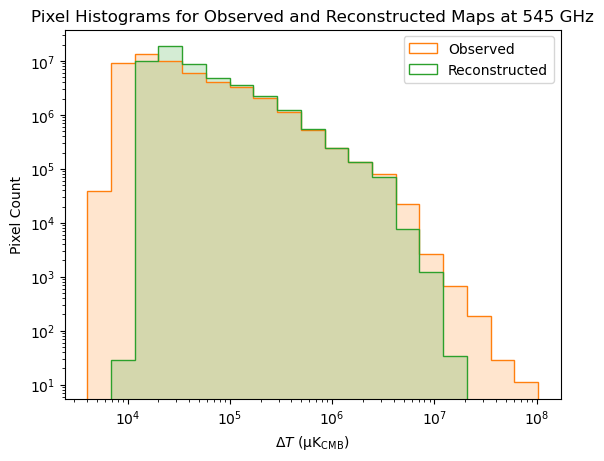

In [812]:
make_hist(545, out_asset=map_hist_asset, show=show_figures)  # ~20s

In [ ]:
plot_differences(857, 
                 symlog_settings, 
                 out_asset=map_fig_asset,
                 show=show_figures)  # LFI freqs take ~20s, HFI freqs take ~60s

In [ ]:
make_hist(857, out_asset=map_hist_asset, show=show_figures)  # ~20s